In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from ecgdetectors import Detectors
from pathlib import Path
from scipy.fftpack import dct
from scipy.fft import fft
from python_speech_features import mfcc
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models
import seaborn as sns
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from scipy.optimize import linear_sum_assignment

## **1.** Base de datos
### **1.1** Elección de filtrado

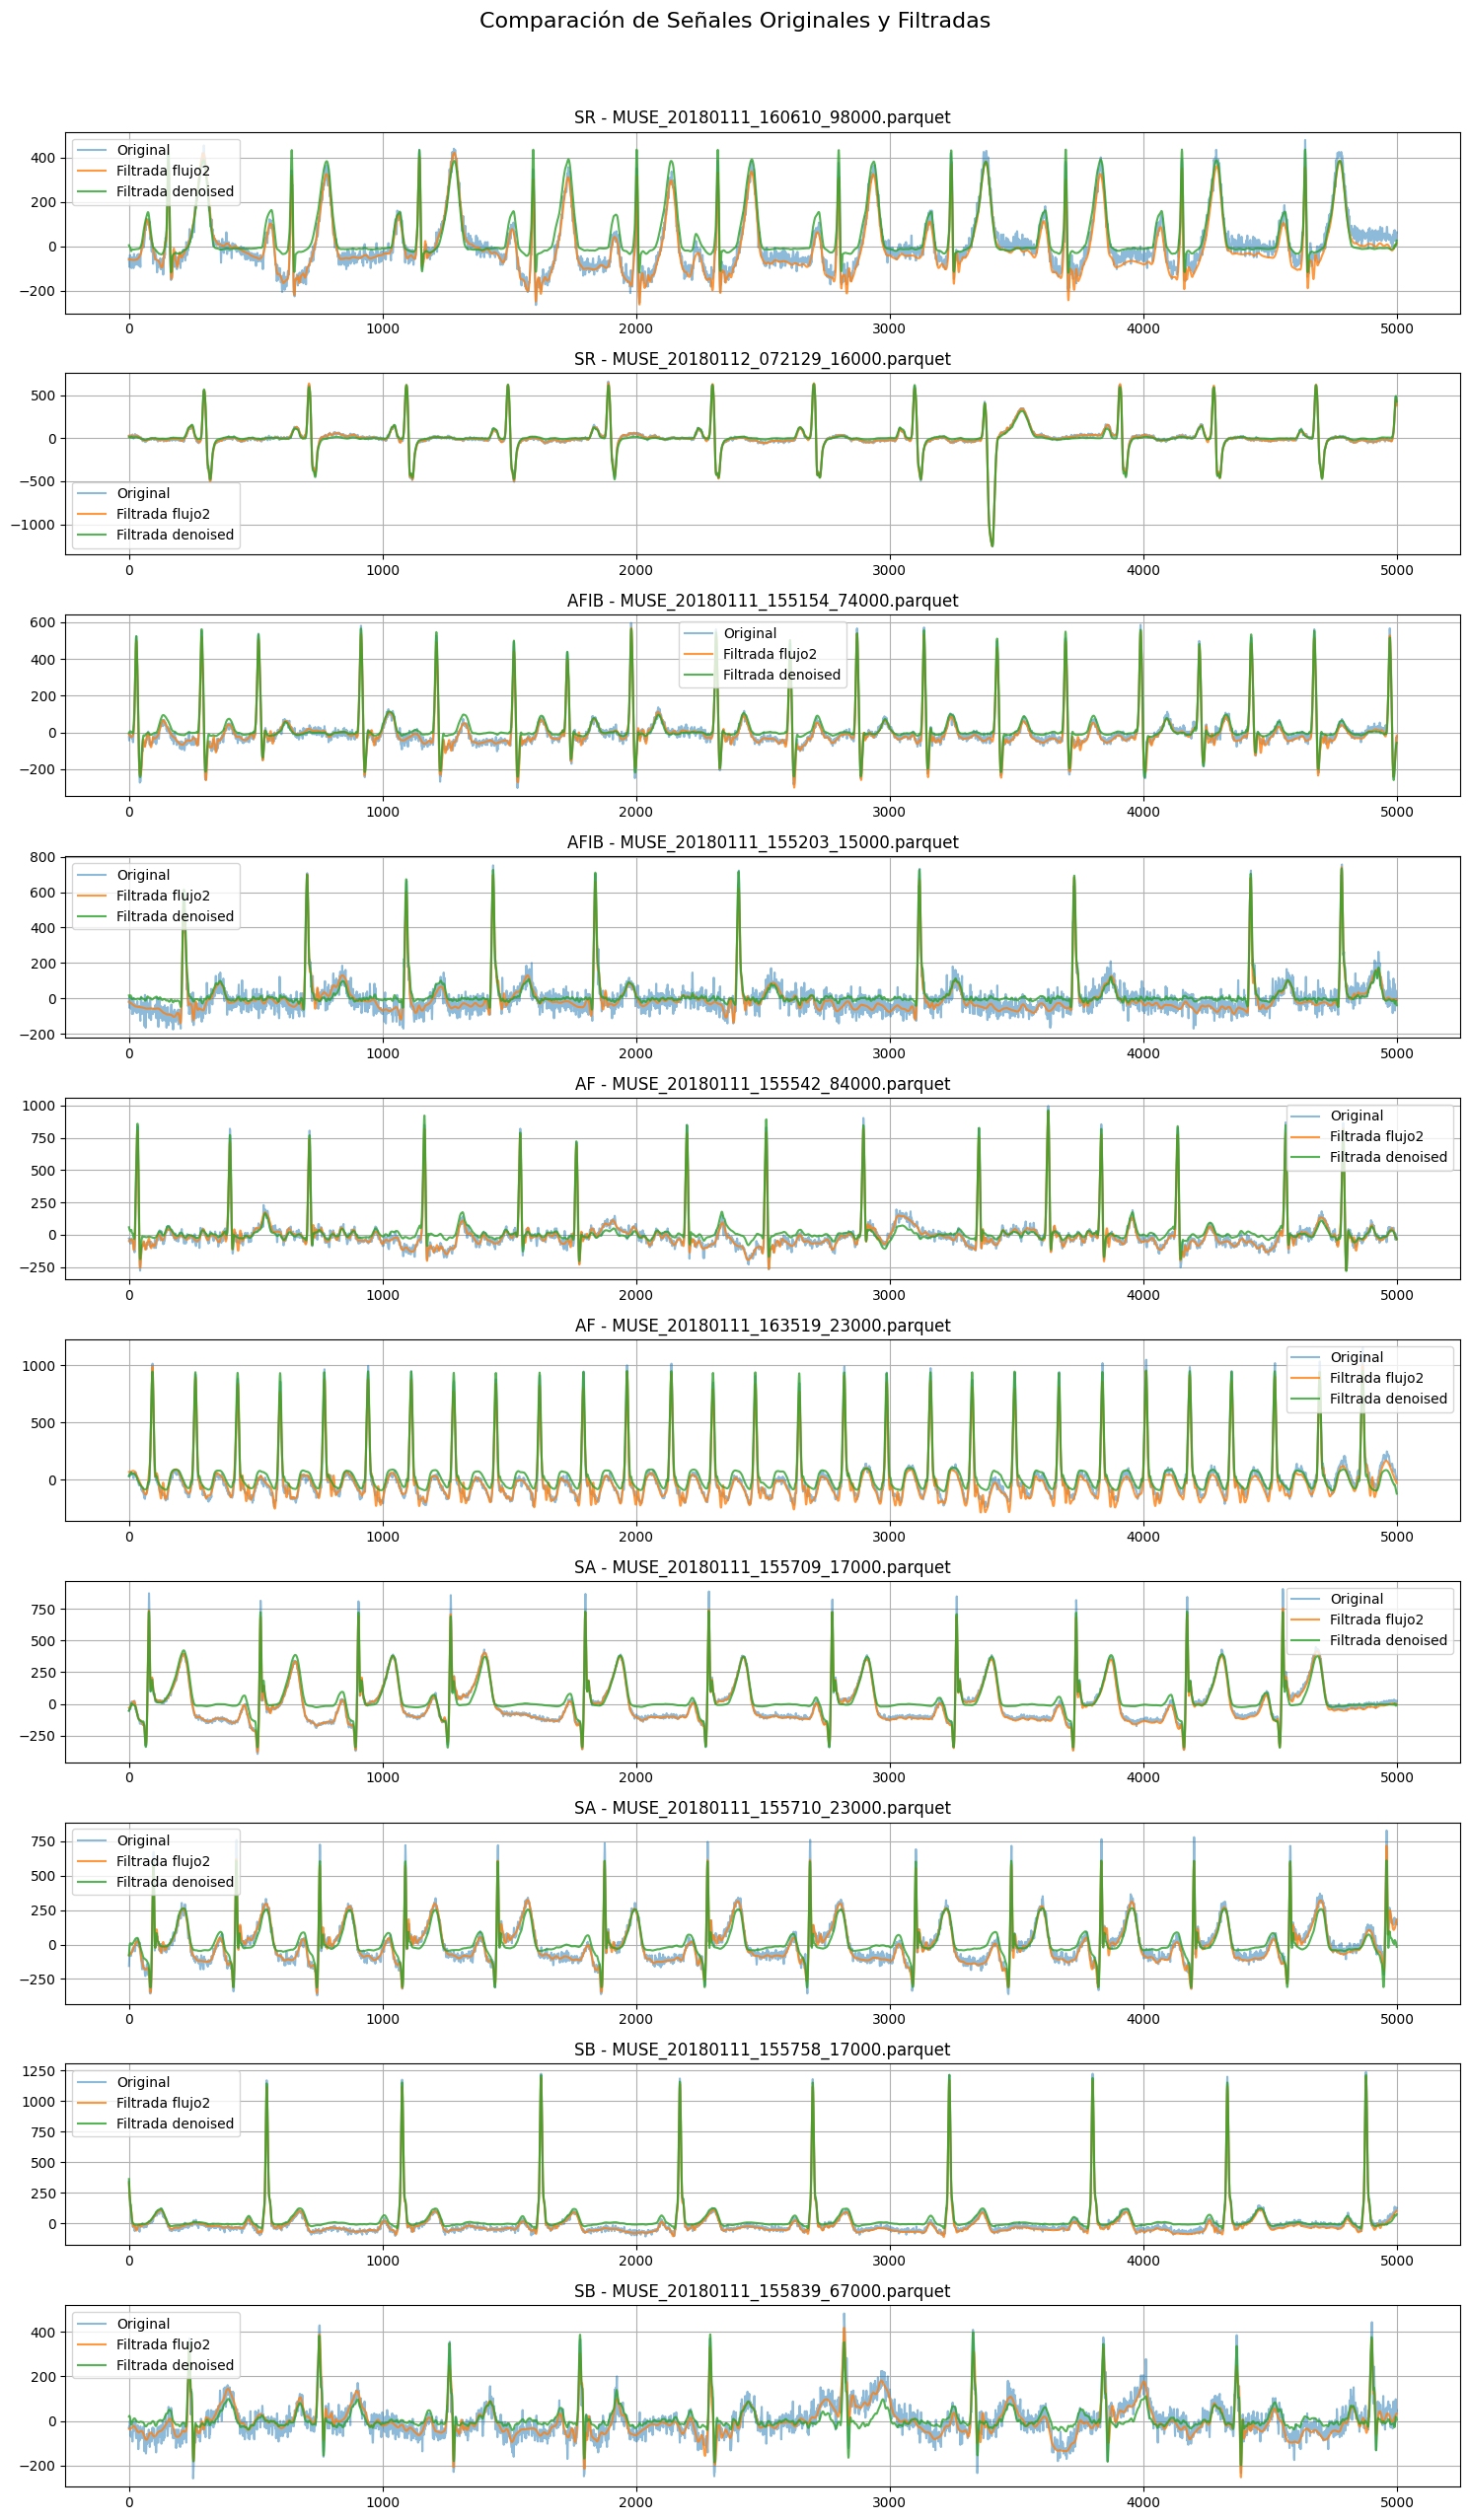

In [5]:
# Parámetros
muestreo_hz = 500
muestras_mostrar = 5000
arritmias = ['SR', 'AFIB', 'AF', 'SA', 'SB']
base_path_original = './data/processed_dii/parquet'
base_path_denoised = './data/processed_Denoised_ii/parquet'
file_flujo2 = 'datafiltro_flujo2.parquet' 

# Cargar parquet
df_flujo2 = pd.read_parquet(file_flujo2)

senales_filtradas = []

for clase in arritmias:
    # Paths y archivos originales y denoised
    clase_path_original = os.path.join(base_path_original, clase)
    archivos_original = [f for f in os.listdir(clase_path_original) if f.endswith('.parquet')][:2]
    
    clase_path_denoised = os.path.join(base_path_denoised, clase)
    archivos_denoised = [f for f in os.listdir(clase_path_denoised) if f.endswith('.parquet')][:2]
    
    # Señales flujo2 para esta clase
    df_flujo2_clase = df_flujo2[df_flujo2['0'] == clase].head(2)
    
    for idx in range(2):
        archivo_ori = archivos_original[idx]
        archivo_den = archivos_denoised[idx]
        
        archivo_path_ori = os.path.join(clase_path_original, archivo_ori)
        archivo_path_den = os.path.join(clase_path_denoised, archivo_den)

        # Original
        df_ori = pd.read_parquet(archivo_path_ori)
        columna_senal_ori = 'II' if 'II' in df_ori.columns else df_ori.columns[0]
        senal_ori = df_ori[columna_senal_ori].values[:muestras_mostrar]

        # Denoised
        df_den = pd.read_parquet(archivo_path_den)
        columna_senal_den = 'II' if 'II' in df_den.columns else df_den.columns[0]
        senal_denoised = df_den[columna_senal_den].values[:muestras_mostrar]

        # Flujo2: la señal está en la columna 3 (índice 3)
        senal_flujo2_raw = df_flujo2_clase.iloc[idx]['3']
        senal_flujo2 = np.array(senal_flujo2_raw)[:muestras_mostrar]

        senales_filtradas.append((clase, archivo_ori, senal_ori, senal_flujo2, senal_denoised))

# Guardar las señales completas
df_datafil = pd.DataFrame(senales_filtradas, columns=['clase', 'archivo', 'original', 'flujo2', 'denoised'])
df_datafil.to_parquet("senales_filtradas.parquet", index=False)

# Graficar
plt.figure(figsize=(15, 25))

for i, (clase, archivo, original, flujo2, denoised) in enumerate(senales_filtradas):
    plt.subplot(10, 1, i + 1)
    plt.plot(original, label='Original', alpha=0.5)
    plt.plot(flujo2, label='Filtrada flujo2', alpha=0.8)
    plt.plot(denoised, label='Filtrada denoised', alpha=0.8)
    plt.title(f'{clase} - {archivo}')
    plt.legend()
    plt.grid(True)

plt.suptitle("Comparación de Señales Originales y Filtradas", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


#### **1.2** Metricas para elección de filtrado

In [6]:
df = pd.read_parquet('senales_filtradas.parquet')

resultados = []

for _, row in df.iterrows():
    clase = row['clase']
    archivo = row['archivo']
    
    try:
        senal_ori = np.array(row['original'])
        senal_flujo2 = np.array(row['flujo2'])
        senal_denoised = np.array(row['denoised'])
    except Exception as e:
        print(f"Error leyendo señales del archivo {archivo}: {e}")
        continue
    
    min_len = min(len(senal_ori), len(senal_flujo2), len(senal_denoised))
    senal_ori = senal_ori[:min_len]
    senal_flujo2 = senal_flujo2[:min_len]
    senal_denoised = senal_denoised[:min_len]
    
    # Métricas
    rmse_flujo2 = np.sqrt(np.mean((senal_ori - senal_flujo2) ** 2))
    rmse_denoised = np.sqrt(np.mean((senal_ori - senal_denoised) ** 2))
    
    corr_flujo2 = np.corrcoef(senal_ori, senal_flujo2)[0,1]
    corr_denoised = np.corrcoef(senal_ori, senal_denoised)[0,1]
    
    resultados.append({
        'clase': clase,
        'archivo': archivo,
        'rmse_flujo2': rmse_flujo2,
        'rmse_denoised': rmse_denoised,
        'corr_flujo2': corr_flujo2,
        'corr_denoised': corr_denoised
    })

# DataFrame Resultados
df_metricas = pd.DataFrame(resultados)

df_metricas['mejor_rmse'] = np.where(df_metricas['rmse_flujo2'] < df_metricas['rmse_denoised'], 'flujo2', 'denoised')
df_metricas['mejor_corr'] = np.where(df_metricas['corr_flujo2'] > df_metricas['corr_denoised'], 'flujo2', 'denoised')

# Resultados
df_metricas.to_excel("metricas_comparacion.xlsx", index=False)

# Resumen
print("\nResumen promedio por clase:")
print(df_metricas.groupby('clase').mean(numeric_only=True))
print("\nConteo de veces que cada filtro ganó:")
print("Por RMSE:")
print(df_metricas['mejor_rmse'].value_counts())
print("Por correlación:")
print(df_metricas['mejor_corr'].value_counts())




Resumen promedio por clase:
       rmse_flujo2  rmse_denoised  corr_flujo2  corr_denoised
clase                                                        
AF       34.414384      58.276848     0.982803       0.962576
AFIB     26.592835      37.871164     0.964697       0.949604
SA       25.612907      65.308694     0.986796       0.932422
SB       24.665445      41.862041     0.953778       0.902648
SR       21.387832      40.888130     0.988605       0.958019

Conteo de veces que cada filtro ganó:
Por RMSE:
mejor_rmse
flujo2    10
Name: count, dtype: int64
Por correlación:
mejor_corr
flujo2    10
Name: count, dtype: int64


## **2.** Extracción caracteristicas
### Arritmias seleccionadas son: SR, AF, AFIB, SA

In [7]:
df_senales = pd.read_parquet('./senalfiltradas_flujo2.parquet')
print(df_senales.columns)
df_senales.head()

Index(['clase', 'archivo', 'senal_filtrada_flujo2'], dtype='object')


,clase,archivo,senal_filtrada_flujo2
0,AFIB,MUSE_20180111_155154_74000.parquet,"[-11.065319742631498, -12.302326882218605, -13..."
1,AFIB,MUSE_20180111_155203_15000.parquet,"[-19.258469607353547, -19.96199273395733, -20...."
2,AFIB,MUSE_20180111_155903_57000.parquet,"[-33.54641586867559, -34.35929370801589, -35.0..."
3,AFIB,MUSE_20180111_155945_02000.parquet,"[-8.33946778068508, -9.105545060922339, -9.936..."
4,AFIB,MUSE_20180111_160053_89000.parquet,"[25.89617451809073, 26.01544449803158, 26.1240..."


### **2.1** Extracción de picos R: Numero de picos 

In [8]:
archivo_parquet = './senalfiltradas_flujo2.parquet'
arritmias = ['SA', 'AFIB', 'AF', 'SR']

detector = Detectors(muestreo_hz)
df = pd.read_parquet(archivo_parquet)
df = df[df['clase'].isin(arritmias)].reset_index(drop=True)

resultados_picos = []
for idx, row in df.iterrows():
    try:
        arritmia = row['clase']
        archivo = row['archivo']
        señal = np.array(row['senal_filtrada_flujo2'], dtype=float)

        # Picos R
        picos_r = detector.christov_detector(señal)

        # Resultados
        resultados_picos.append({
            'archivo': archivo,
            'arritmia': arritmia,
            'num_picos': len(picos_r),
            'picos_r': picos_r
        })

    except Exception as e:
        print(f"Error procesando fila {idx}: {str(e)}")

# DataFrame
df_picos = pd.DataFrame(resultados_picos)
print(df_picos.groupby('arritmia')['num_picos'].describe())

# Guardar
df_picos.to_parquet('./resultados_picos_r.parquet', index=False)


           count       mean       std  min   25%   50%   75%   max
arritmia                                                          
AF         445.0  20.262921  5.955586  8.0  16.0  20.0  24.0  43.0
AFIB      1780.0  16.806742  4.845651  2.0  13.0  16.0  20.0  37.0
SA         399.0  14.704261  4.732838  9.0  12.0  13.0  15.0  35.0
SR        1826.0  14.786418  4.114439  5.0  12.0  14.0  16.0  36.0


### **2.2** Extracción de RMSSD, SDNN, PNN50, meanNN

In [9]:
df_picos = pd.read_parquet('./resultados_picos_r.parquet')

arritmias = ['SR', 'AFIB', 'AF', 'SA']
# listas
rmssd_list = []
sdnn_list = []
pnn50_list = []
meannn_list = []

for picos in df_picos['picos_r']:
    # intervalos RR
    rr_intervals = np.diff(picos) / muestreo_hz
    rr_ms = rr_intervals * 1000

    if len(rr_ms) > 0:
        # meanNN
        meanNN = np.mean(rr_ms)
        # SDNN
        SDNN = np.std(rr_ms)
        # RMSSD
        diffs = np.diff(rr_ms)
        RMSSD = np.sqrt(np.mean(diffs**2)) if len(diffs) > 0 else np.nan
        # PNN50
        NN50 = np.sum(np.abs(diffs) > 50)
        PNN50 = (NN50 / len(diffs)) * 100 if len(diffs) > 0 else np.nan
    else:
        meanNN = SDNN = RMSSD = PNN50 = np.nan

    rmssd_list.append(RMSSD)
    sdnn_list.append(SDNN)
    pnn50_list.append(PNN50)
    meannn_list.append(meanNN)

# Columnas nuevas al DataFrame
df_picos['RMSSD'] = rmssd_list
df_picos['SDNN'] = sdnn_list
df_picos['PNN50'] = pnn50_list
df_picos['meanNN'] = meannn_list

print(df_picos.head())



                              archivo arritmia  num_picos  \
0  MUSE_20180111_155154_74000.parquet     AFIB         18   
1  MUSE_20180111_155203_15000.parquet     AFIB         10   
2  MUSE_20180111_155903_57000.parquet     AFIB         27   
3  MUSE_20180111_155945_02000.parquet     AFIB         15   
4  MUSE_20180111_160053_89000.parquet     AFIB         13   

                                             picos_r       RMSSD        SDNN  \
0  [287, 511, 915, 1214, 1519, 1732, 1981, 2315, ...  135.251617   93.915518   
1  [145, 705, 1098, 1439, 1843, 2407, 3115, 3727,...  322.406576  270.285629   
2  [240, 465, 708, 950, 1192, 1637, 1864, 2059, 2...  147.165213  166.401756   
3  [155, 309, 614, 930, 1181, 1507, 1769, 2128, 2...  152.080950  126.094878   
4  [181, 570, 856, 1375, 1696, 2022, 2597, 3058, ...  286.402133  172.313667   

        PNN50       meanNN  
0   62.500000   550.588235  
1  100.000000  1030.888889  
2   36.000000   360.384615  
3   76.923077   633.714286  
4   90.

### **2.3** Extracción de DCT, FFT, MFCC

In [10]:
df_senales = df_senales[df_senales['clase'].isin(arritmias)].reset_index(drop=True)

# Listas
dct_list, fft_list, mfcc_list, archivos_list = [], [], [], []
for idx, row in df_senales.iterrows():
    archivo = row['archivo']
    señal = np.array(row['senal_filtrada_flujo2'], dtype=float)
    # DCT
    dct_values = dct(señal, norm='ortho')[:20]
    # FFT
    fft_values = np.abs(fft(señal))[:20]
    # MFCC
    try:
        mfcc_values = mfcc(señal, samplerate=muestreo_hz, numcep=13)
        mfcc_mean = np.mean(mfcc_values, axis=0)
    except Exception as e:
        print(f"Error calculando MFCC en {archivo}: {e}")
        mfcc_mean = np.zeros(13)

    archivos_list.append(archivo)
    dct_list.append(dct_values)
    fft_list.append(fft_values)
    mfcc_list.append(mfcc_mean)

# DataFrame
df_features = pd.DataFrame({
    'archivo': archivos_list,
    'DCT': [np.mean(vals) for vals in dct_list],
    'FFT': [np.mean(vals) for vals in fft_list],
    'MFCC': mfcc_list
})

# MFCC 6 primeros coeficientes
df_mfcc_cols = pd.DataFrame(mfcc_list, columns=[f'mfcc_{i+1}' for i in range(len(mfcc_list[0]))])
df_mfcc_6 = df_mfcc_cols.iloc[:, :6].copy()  # tomar solo los 6 primeros

# Concatenar con el DataFrame
df_features_expanded = pd.concat([df_features.drop(columns=['MFCC']), df_mfcc_6], axis=1)
df_final = pd.merge(df_picos, df_features_expanded, on='archivo', how='inner')

print(df_final.head())

                              archivo arritmia  num_picos  \
0  MUSE_20180111_155154_74000.parquet     AFIB         18   
1  MUSE_20180111_155203_15000.parquet     AFIB         10   
2  MUSE_20180111_155903_57000.parquet     AFIB         27   
3  MUSE_20180111_155945_02000.parquet     AFIB         15   
4  MUSE_20180111_160053_89000.parquet     AFIB         13   

                                             picos_r       RMSSD        SDNN  \
0  [287, 511, 915, 1214, 1519, 1732, 1981, 2315, ...  135.251617   93.915518   
1  [145, 705, 1098, 1439, 1843, 2407, 3115, 3727,...  322.406576  270.285629   
2  [240, 465, 708, 950, 1192, 1637, 1864, 2059, 2...  147.165213  166.401756   
3  [155, 309, 614, 930, 1181, 1507, 1769, 2128, 2...  152.080950  126.094878   
4  [181, 570, 856, 1375, 1696, 2022, 2597, 3058, ...  286.402133  172.313667   

        PNN50       meanNN         DCT           FFT    mfcc_1     mfcc_2  \
0   62.500000   550.588235    9.434268  13440.343352  4.107251  18.250557  

### **2.4** Extracción de minNN, maxNN, medianNN, rangeNN, Skew, Kurtosis

In [11]:
df_final = df_final[df_final['arritmia'].isin(arritmias)].reset_index(drop=True)

# Listas
minNN_list, maxNN_list, medianNN_list, rangeNN_list, skewness_list, kurtosis_list = [], [], [], [], [], []
archivos_list = df_final['archivo'].tolist()

for picos in df_final['picos_r']:
    rr_intervals = np.diff(picos) / muestreo_hz
    rr_ms = rr_intervals * 1000

    if len(rr_ms) > 0:
        minNN = np.min(rr_ms)
        maxNN = np.max(rr_ms)
        medianNN = np.median(rr_ms)
        rangeNN = maxNN - minNN
        skew_val = skew(rr_ms)
        kurt_val = kurtosis(rr_ms)
    else:
        minNN = maxNN = medianNN = rangeNN = skew_val = kurt_val = np.nan

    minNN_list.append(minNN)
    maxNN_list.append(maxNN)
    medianNN_list.append(medianNN)
    rangeNN_list.append(rangeNN)
    skewness_list.append(skew_val)
    kurtosis_list.append(kurt_val)

# Dataframe
df_nuevas = pd.DataFrame({
    'archivo': archivos_list,
    'minNN': minNN_list,
    'maxNN': maxNN_list,
    'medianNN': medianNN_list,
    'rangeNN': rangeNN_list,
    'skewness': skewness_list,
    'kurtosis': kurtosis_list
})

# Nuevas columnas
df_final = pd.merge(df_final, df_nuevas, on='archivo', how='left')
print(df_final.head())
print(df_final.columns)

# Guardar
df_final.to_parquet('./df_final.parquet', index=False)


                              archivo arritmia  num_picos  \
0  MUSE_20180111_155154_74000.parquet     AFIB         18   
1  MUSE_20180111_155203_15000.parquet     AFIB         10   
2  MUSE_20180111_155903_57000.parquet     AFIB         27   
3  MUSE_20180111_155945_02000.parquet     AFIB         15   
4  MUSE_20180111_160053_89000.parquet     AFIB         13   

                                             picos_r       RMSSD        SDNN  \
0  [287, 511, 915, 1214, 1519, 1732, 1981, 2315, ...  135.251617   93.915518   
1  [145, 705, 1098, 1439, 1843, 2407, 3115, 3727,...  322.406576  270.285629   
2  [240, 465, 708, 950, 1192, 1637, 1864, 2059, 2...  147.165213  166.401756   
3  [155, 309, 614, 930, 1181, 1507, 1769, 2128, 2...  152.080950  126.094878   
4  [181, 570, 856, 1375, 1696, 2022, 2597, 3058, ...  286.402133  172.313667   

        PNN50       meanNN         DCT           FFT  ...     mfcc_3  \
0   62.500000   550.588235    9.434268  13440.343352  ...  12.234969   
1  100.0

In [12]:
print(df_final.columns)

Index(['archivo', 'arritmia', 'num_picos', 'picos_r', 'RMSSD', 'SDNN', 'PNN50',
       'meanNN', 'DCT', 'FFT', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4',
       'mfcc_5', 'mfcc_6', 'minNN', 'maxNN', 'medianNN', 'rangeNN', 'skewness',
       'kurtosis'],
      dtype='object')


## **3.** Tres arquitecturas de red para las 4 arritmias


=== Entrenando: Red Pequeña ===
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
              precision    recall  f1-score   support

          AF       0.67      0.47      0.55       133
        AFIB       0.86      0.90      0.88       534
          SA       0.67      0.50      0.57       120
          SR       0.87      0.94      0.90       548

    accuracy                           0.84      1335
   macro avg       0.77      0.70      0.73      1335
weighted avg       0.83      0.84      0.83      1335



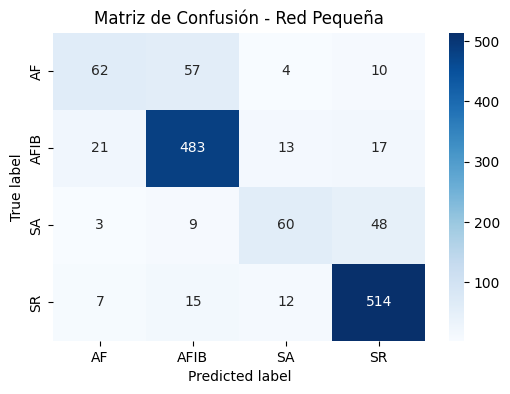


=== Entrenando: Red Mediana ===
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

          AF       0.64      0.38      0.48       133
        AFIB       0.83      0.93      0.88       534
          SA       0.58      0.57      0.57       120
          SR       0.90      0.89      0.89       548

    accuracy                           0.83      1335
   macro avg       0.74      0.69      0.71      1335
weighted avg       0.82      0.83      0.82      1335



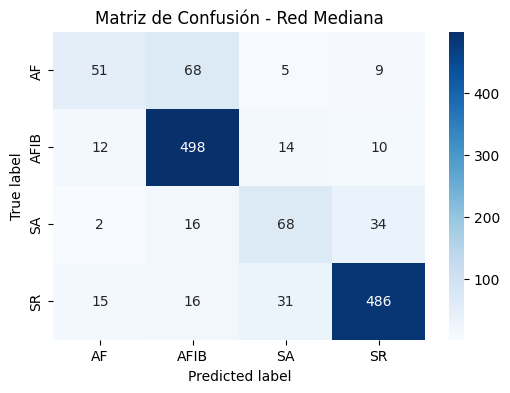


=== Entrenando: Red Grande ===
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
              precision    recall  f1-score   support

          AF       0.49      0.47      0.48       133
        AFIB       0.84      0.88      0.86       534
          SA       0.71      0.38      0.50       120
          SR       0.86      0.92      0.89       548

    accuracy                           0.81      1335
   macro avg       0.73      0.66      0.68      1335
weighted avg       0.80      0.81      0.80      1335



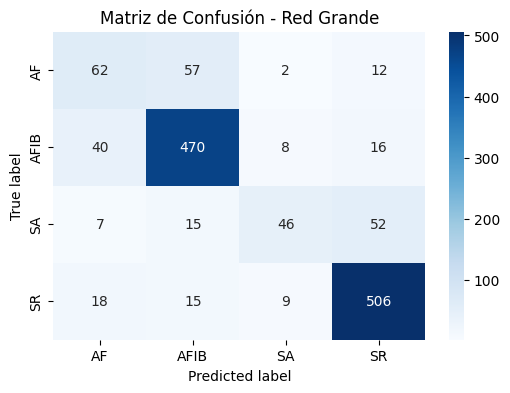

In [13]:
# Datos
df = pd.read_parquet('./df_final.parquet')
X = df.drop(columns=['archivo', 'arritmia', 'picos_r'])  # quitamos columnas no numéricas ni útiles para el modelo
y = df['arritmia']

# Etiquetas
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Matriz de confusión
def plot_confusion(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Arquitecturas
architectures = {
    "Red Pequeña": [64, 32],
    "Red Mediana": [128, 64, 32],
    "Red Grande": [256, 128, 64, 32]
}

# Entrenar y evaluar cada arquitectura
for name, layers_units in architectures.items():
    print(f"\n=== Entrenando: {name} ===")

    # Modelo
    model = models.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    for units in layers_units:
        model.add(layers.Dense(units, activation='relu'))
    model.add(layers.Dense(len(np.unique(y_encoded)), activation='softmax'))

    # Compilar
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Entrenar
    history = model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0, validation_split=0.2)

    # Predecir
    y_pred = np.argmax(model.predict(X_test), axis=1)

    # Reporte
    print(classification_report(y_test, y_pred, target_names=encoder.classes_))

    # Matriz de confusión
    plot_confusion(y_test, y_pred, labels=encoder.classes_, title=f'Matriz de Confusión - {name}')


## **4.** Tres arquitecturas de red para dos arritmias


=== Entrenando: Red Pequeña ===
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

        AFIB       0.96      0.95      0.95       534
          SR       0.95      0.96      0.96       548

    accuracy                           0.96      1082
   macro avg       0.96      0.96      0.96      1082
weighted avg       0.96      0.96      0.96      1082



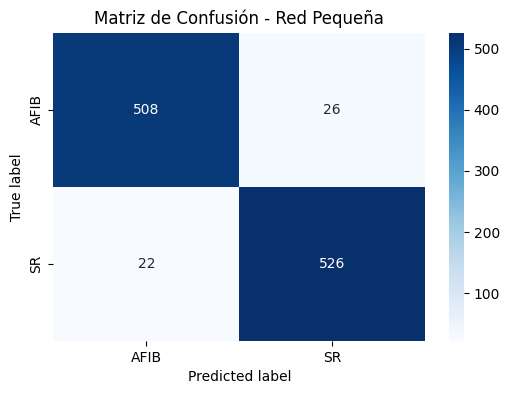


=== Entrenando: Red Mediana ===
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
              precision    recall  f1-score   support

        AFIB       0.94      0.96      0.95       534
          SR       0.96      0.94      0.95       548

    accuracy                           0.95      1082
   macro avg       0.95      0.95      0.95      1082
weighted avg       0.95      0.95      0.95      1082



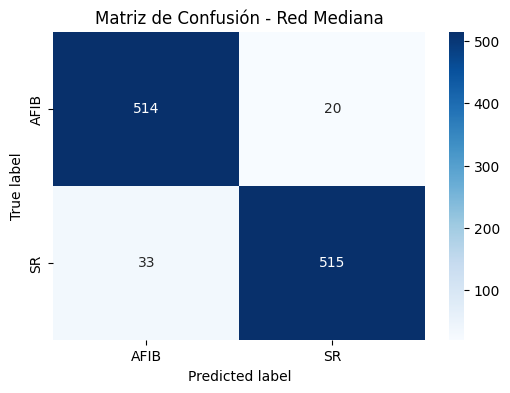


=== Entrenando: Red Grande ===
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

        AFIB       0.96      0.96      0.96       534
          SR       0.96      0.96      0.96       548

    accuracy                           0.96      1082
   macro avg       0.96      0.96      0.96      1082
weighted avg       0.96      0.96      0.96      1082



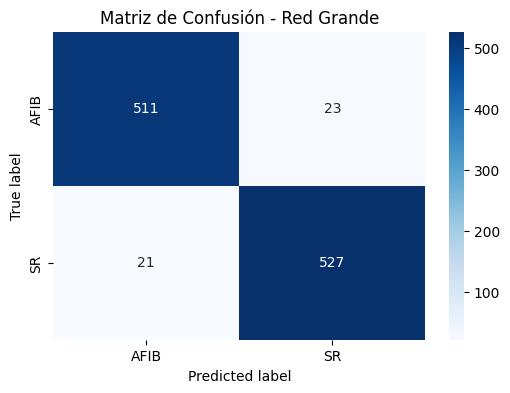

In [14]:
# Datos
df = pd.read_parquet('./df_final.parquet')

# Dos arritmias
df = df[df['arritmia'].isin(['AFIB', 'SR'])]
X = df.drop(columns=['archivo', 'arritmia', 'picos_r'])  # quitamos columnas no útiles
y = df['arritmia']

# Etiquetas
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Matriz de confusión
def plot_confusion(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Arquitecturas
architectures = {
    "Red Pequeña": [64, 32],
    "Red Mediana": [128, 64, 32],
    "Red Grande": [256, 128, 64, 32]
}

# Entrenar y evaluar cada arquitectura
for name, layers_units in architectures.items():
    print(f"\n=== Entrenando: {name} ===")

    # Modelo
    model = models.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    for units in layers_units:
        model.add(layers.Dense(units, activation='relu'))
    model.add(layers.Dense(len(np.unique(y_encoded)), activation='softmax'))

    # Compilar
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Entrenar
    history = model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0, validation_split=0.2)

    # Predecir
    y_pred = np.argmax(model.predict(X_test), axis=1)

    # Reporte
    print(classification_report(y_test, y_pred, target_names=encoder.classes_))

    # Matriz de confusión
    plot_confusion(y_test, y_pred, labels=encoder.classes_, title=f'Matriz de Confusión - {name}')


## **5.** Arquitecturas de red con XGBoost

C:\Users\fabio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [22:58:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

          AF       0.74      0.44      0.55       133
        AFIB       0.84      0.93      0.88       534
          SA       0.67      0.48      0.56       120
          SR       0.88      0.93      0.91       548

    accuracy                           0.84      1335
   macro avg       0.78      0.70      0.73      1335
weighted avg       0.83      0.84      0.83      1335



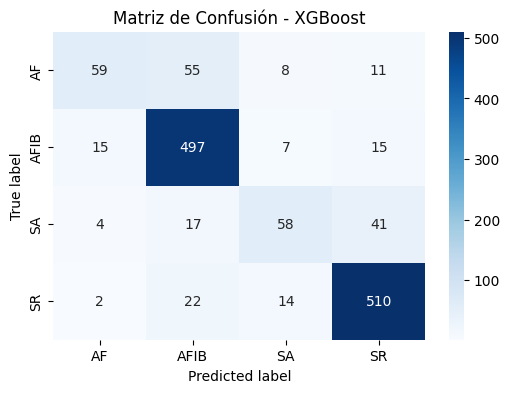

In [15]:
df = pd.read_parquet('./df_final.parquet')

X = df.drop(columns=['archivo', 'arritmia', 'picos_r'])
y = df['arritmia']

# Etiquetas
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Separar Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Matriz de confusión
def plot_confusion(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Modelo XGBoost
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model_xgb.fit(X_train, y_train)

# Predecir y evaluar
y_pred = model_xgb.predict(X_test)

# Reporte
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Matriz de confusión
plot_confusion(y_test, y_pred, labels=encoder.classes_, title='Matriz de Confusión - XGBoost')


## **6.** Arquitecturas K-means y máquinas de soporte vectorial (SVM)
### **6.1** K-means:

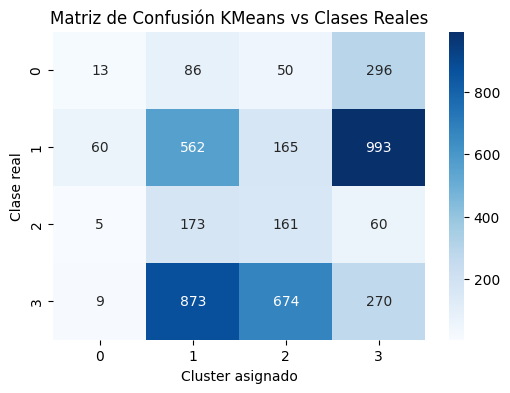

Accuracy de KMeans después de reordenar clusters: 0.4584

=== Classification Report KMeans (clusters vs clases reales) ===
              precision    recall  f1-score   support

          AF       0.15      0.03      0.05       445
        AFIB       0.33      0.32      0.32      1780
          SA       0.15      0.40      0.22       399
          SR       0.17      0.15      0.16      1826

    accuracy                           0.23      4450
   macro avg       0.20      0.22      0.19      4450
weighted avg       0.23      0.23      0.22      4450



In [16]:
# Datos
df = pd.read_parquet('./df_final.parquet')

X = df.drop(columns=['archivo', 'arritmia', 'picos_r'])  # usa solo columnas numéricas
y = df['arritmia']

# Etiquetas
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Matriz de confusión
cm = confusion_matrix(y_encoded, clusters)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión KMeans vs Clases Reales')
plt.xlabel('Cluster asignado')
plt.ylabel('Clase real')
plt.show()

# Accuracy
cost_matrix = -cm 
row_ind, col_ind = linear_sum_assignment(cost_matrix)
total_correct = cm[row_ind, col_ind].sum()
accuracy = total_correct / np.sum(cm)
print(f'Accuracy de KMeans después de reordenar clusters: {accuracy:.4f}')
print("\n=== Classification Report KMeans (clusters vs clases reales) ===")
print(classification_report(y_encoded, clusters, target_names=encoder.classes_))


### **6.2** Máquinas de soporte vectorial (SVM):

🔍 Resultados para SVM (multiclase)
              precision    recall  f1-score   support

          AF       0.78      0.34      0.47       133
        AFIB       0.81      0.94      0.87       534
          SA       0.75      0.36      0.49       120
          SR       0.85      0.94      0.89       548

    accuracy                           0.83      1335
   macro avg       0.80      0.64      0.68      1335
weighted avg       0.82      0.83      0.81      1335



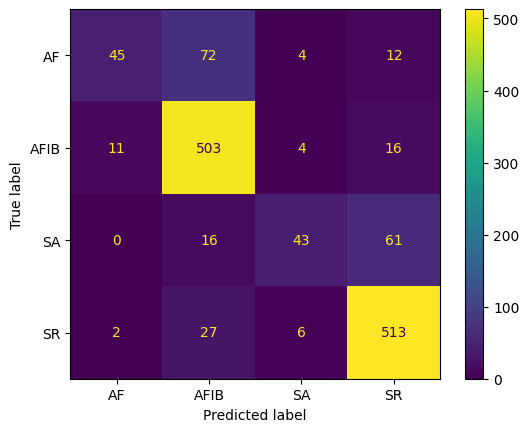

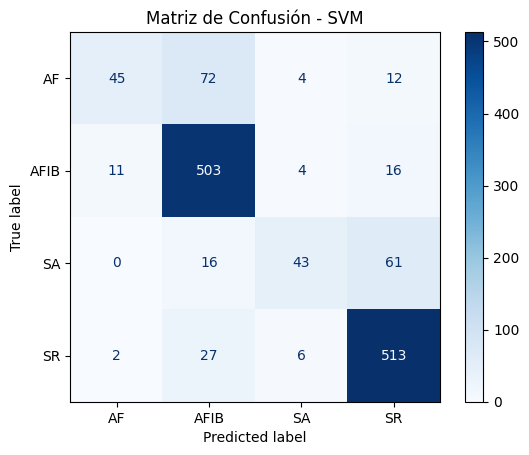

In [17]:
# Datos
df = pd.read_parquet('./df_final.parquet')

# Preparar X e y
X = df.drop(columns=['archivo', 'arritmia', 'picos_r'])  # solo columnas numéricas
y = df['arritmia']

# Etiquetas
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train / Test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# SVM
svm_model = SVC(kernel='rbf', decision_function_shape='ovo', C=1, gamma='scale')
svm_model.fit(X_train, y_train)

# Predicción
y_pred_svm = svm_model.predict(X_test)

print("🔍 Resultados para SVM (multiclase)")
print(classification_report(y_test, y_pred_svm, target_names=encoder.classes_))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_svm, display_labels=encoder.classes_).plot(cmap='Blues')
plt.title('Matriz de Confusión - SVM')
plt.show()


### Comparacion mejor modelo

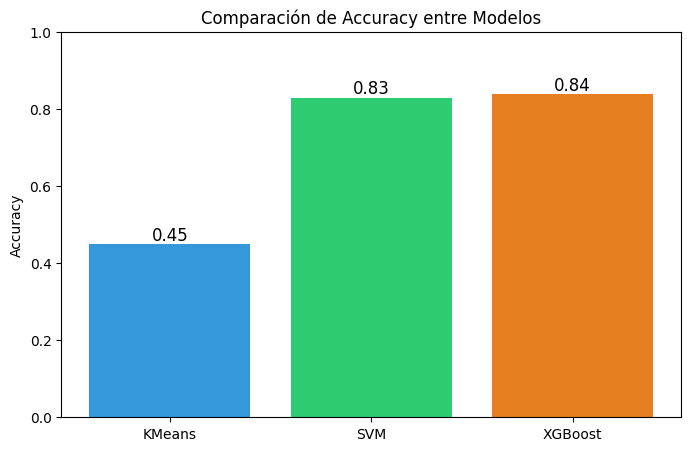

In [ ]:
# Accuracy 
accuracy_kmeans = 0.45   
accuracy_svm = 0.83      
accuracy_xgb = 0.84     

modelos = ['KMeans', 'SVM', 'XGBoost']
accuracies = [accuracy_kmeans, accuracy_svm, accuracy_xgb]

plt.figure(figsize=(8,5))
bars = plt.bar(modelos, accuracies, color=['#3498db','#2ecc71','#e67e22','#9b59b6'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', fontsize=12)

plt.ylim(0, 1) 
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy entre Modelos')
plt.show()
